In [1]:
# Common
import os 
import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf


# Data 
import tensorflow.image as tfi
from tensorflow.keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU


# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [3]:
def load_image(path, SIZE):
    img = load_img(path)
    img = img_to_array(img)
    img = tfi.resize(img, (SIZE, SIZE))
    img = tf.cast(img, tf.float32)
    img = img/255.
    return img

In [4]:
root_path = 'DataSet/'

train_image_paths = sorted(glob(root_path + 'train/US Images/' + "*.png"))
train_mask_paths = sorted(glob(root_path + 'train/Expert mask images/' + "*.png"))

val_image_paths = sorted(glob(root_path + 'val/US Images/' + "*.png"))
val_mask_paths = sorted(glob(root_path + 'val/Expert mask images/' + "*.png"))

test_image_paths = sorted(glob(root_path + 'test/US Images/' + "*.png"))
test_mask_paths = sorted(glob(root_path + 'test/Expert mask images/' + "*.png"))

In [5]:
SIZE = 128

train_images = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))
train_masks = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))

val_images = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))
val_masks = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))

test_images = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))
test_masks = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))

for i,path in tqdm(enumerate(train_image_paths), desc="Train Images"):
    image = load_image(path, SIZE=SIZE)
    train_images[i] = image

for i,path in tqdm(enumerate(train_mask_paths), desc="Train Masks"):
    image = load_image(path, SIZE=SIZE)
    train_masks[i] = image
    
for i,path in tqdm(enumerate(val_image_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_images[i] = image
    
for i,path in tqdm(enumerate(val_mask_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_masks[i] = image

for i,path in tqdm(enumerate(test_image_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_images[i] = image
    
for i,path in tqdm(enumerate(test_mask_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_masks[i] = image

Train Images: 770it [00:19, 39.70it/s]
Train Masks: 770it [00:09, 82.36it/s] 
Valid Masks: 220it [00:06, 36.39it/s]
Valid Masks: 220it [00:02, 103.23it/s]
Test Masks: 110it [00:02, 49.90it/s]
Test Masks: 110it [00:01, 102.68it/s]


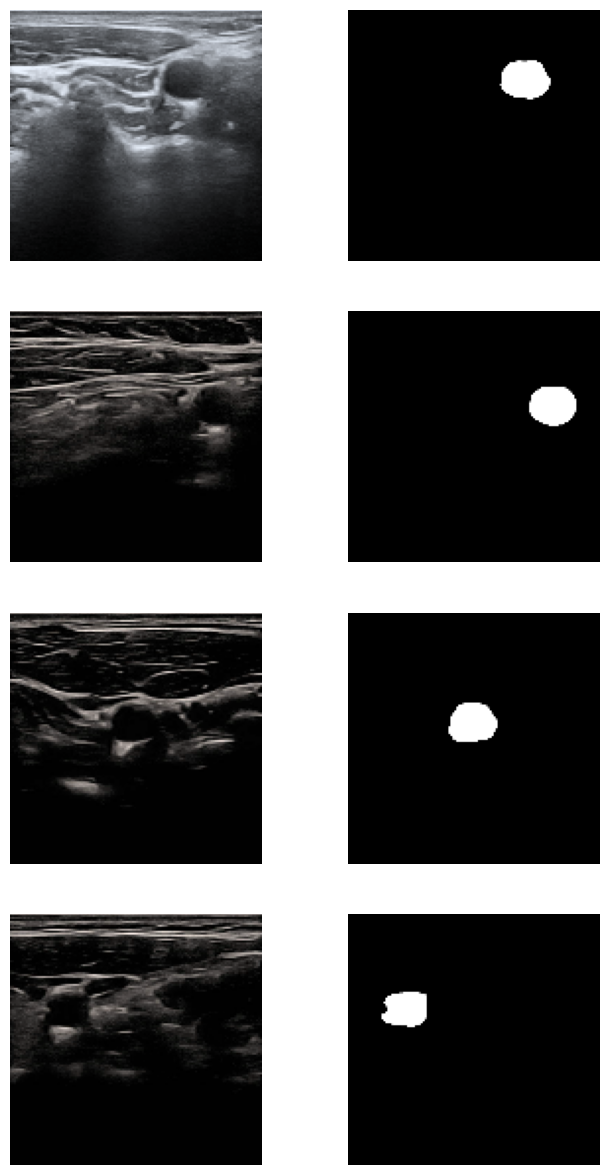

In [6]:
plt.figure(figsize=(8,15))
for i in range(8):
    plt.subplot(4,2,i+1)
    if (i+1)%2!=0:
        rand_id = np.random.randint(len(train_image_paths))
        rand_image = train_images[rand_id]
        rand_mask = train_masks[rand_id]
        show_image(rand_image)
    elif (i+1)%2==0:
        show_image(rand_mask)

In [7]:
# Contraction Block 
class EncoderBlock(Layer):
    
    def __init__(self, filters, rate, pooling=True,**kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPool2D()
        self.bn = BatchNormalization()
    
    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x
    
    def get_config(self):
        base_config = super().get_config()
        return base_config.update({
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        })

In [8]:
# Expansion Block 
class DecoderBlock(Layer):
    
    def __init__(self, filters, rate,**kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
        self.bn = BatchNormalization()
    
    def call(self, X):
        org_x, att_x = X
        x = self.up(org_x)
        x = c_([x, att_x])
        x = self.net(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return base_config.update({
            "filters":self.filters,
            "rate":self.rate
        })

In [9]:
# Attention Gate
class AttentionGate(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same')
        self.normal = Conv2D(filters, kernel_size=3, strides=1, padding='same')
        self.add = Add()
        self.act = ReLU()
        self.learn = Conv2D(1,kernel_size=1,padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.apply = Multiply()
        
        self.drop = Dropout(rate)
        
    def call(self, X):
        net_X, skip_X = X
        
        g = self.normal(net_X)
        h = self.drop(self.down(skip_X)) # this will force it to learn
        
        added = self.add([g,h])
        x = self.act(added)
        x = self.learn(x)
        x = self.resample(x)
        f = self.apply([x, skip_X])
        return f
    
    def get_config(self):
        base_estimator = super().get_config()
        return base_estimator.update({
            "filters":self.filters,
            "rate":self.rate
        })

#     Suggestion :
'''
1. Do not add Dropout
2. Do not add BatchNormalization
3. Do not add LayerNormalization

'''

'\n1. Do not add Dropout\n2. Do not add BatchNormalization\n3. Do not add LayerNormalization\n\n'

In [10]:
# Input 
input_layer = Input(shape=(SIZE, SIZE, 3), name="Input_layer")

# Encoder 
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encodings
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder
a1 = AttentionGate(256,0, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128,0, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64,0, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32,0, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Outputs
output_layer = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid', name="Output_layer")(d4)

# Model
att_unet = Model(
    inputs=[input_layer],
    outputs=[output_layer],
)

In [11]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = np.random.randint(len(val_images))

        image, mask = val_images[i], val_masks[i]
        pred_mask = self.model.predict(image[np.newaxis,...])[0]
        plt.figure(figsize=(15,8))
        plt.subplot(1,4,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,4,2)
        show_image(mask, title="Original Mask")
        
        plt.subplot(1,4,3)
        show_image(pred_mask, title="Predicted Mask")
        
        
        plt.tight_layout()
        plt.show()

In [12]:
CALLBACKS = [
    ModelCheckpoint("Attention-UNet.h5",save_best_only=True),
    ShowProgress()
]

In [13]:
# Compiling
att_unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2, name="IoU")]
)

Epoch 1/30
193/193 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.3561 - IoU: 0.4885

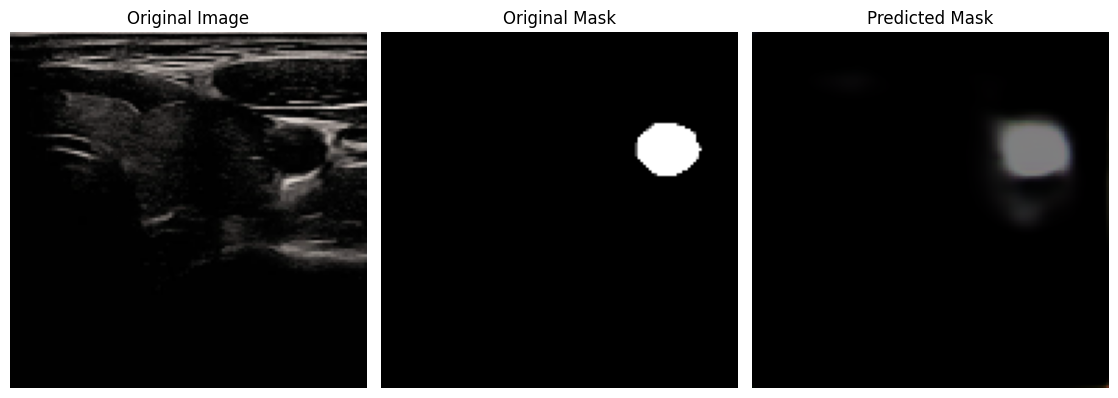

193/193 [==============================] - 227s 1s/step - loss: 0.2038 - accuracy: 0.3561 - IoU: 0.4885 - val_loss: 0.0312 - val_accuracy: 0.4238 - val_IoU: 0.4884
Epoch 2/30
193/193 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.4685 - IoU: 0.4887

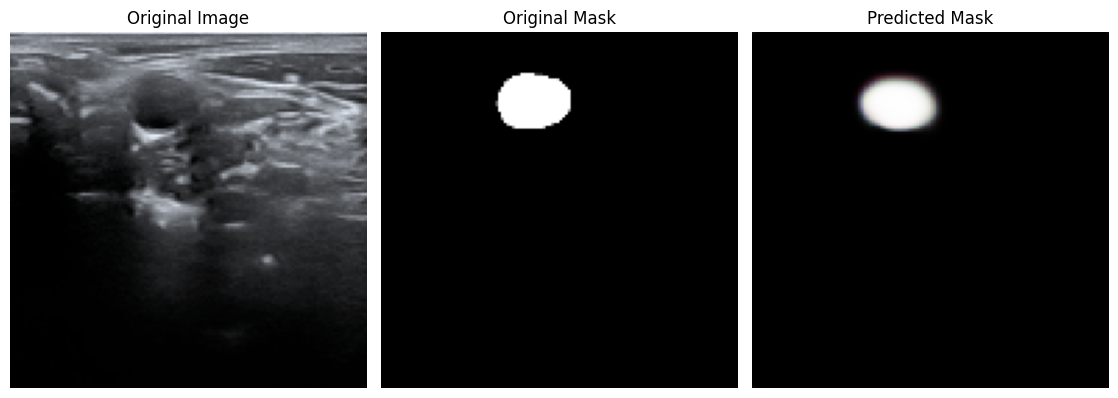

193/193 [==============================] - 230s 1s/step - loss: 0.0199 - accuracy: 0.4685 - IoU: 0.4887 - val_loss: 0.0112 - val_accuracy: 0.9350 - val_IoU: 0.4884
Epoch 3/30
193/193 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.4583 - IoU: 0.4989

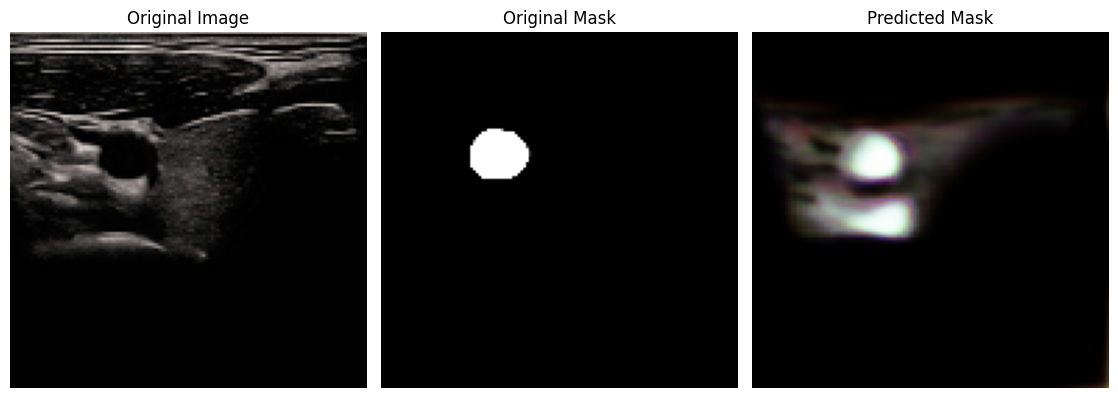

193/193 [==============================] - 228s 1s/step - loss: 0.0187 - accuracy: 0.4583 - IoU: 0.4989 - val_loss: 0.0611 - val_accuracy: 0.9059 - val_IoU: 0.4884
Epoch 4/30
193/193 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.5535 - IoU: 0.4963

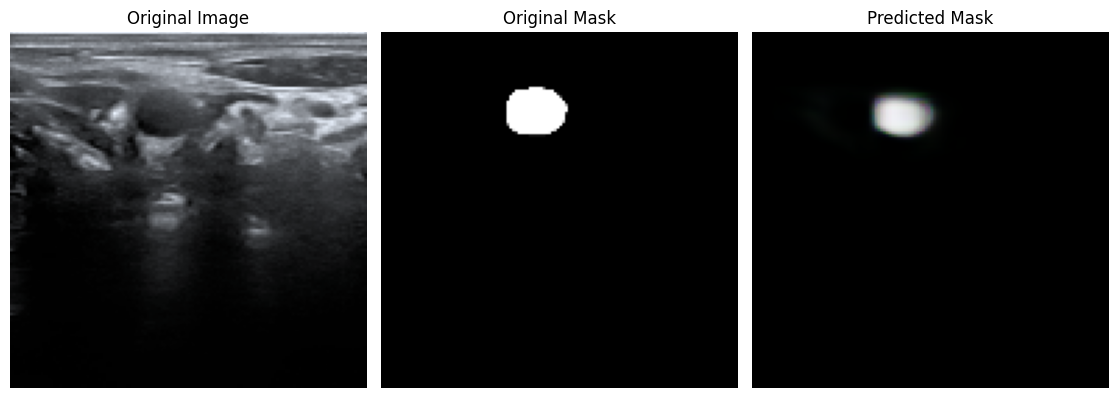

193/193 [==============================] - 228s 1s/step - loss: 0.0192 - accuracy: 0.5535 - IoU: 0.4963 - val_loss: 0.0139 - val_accuracy: 0.5258 - val_IoU: 0.4982
Epoch 5/30
193/193 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.6516 - IoU: 0.5001

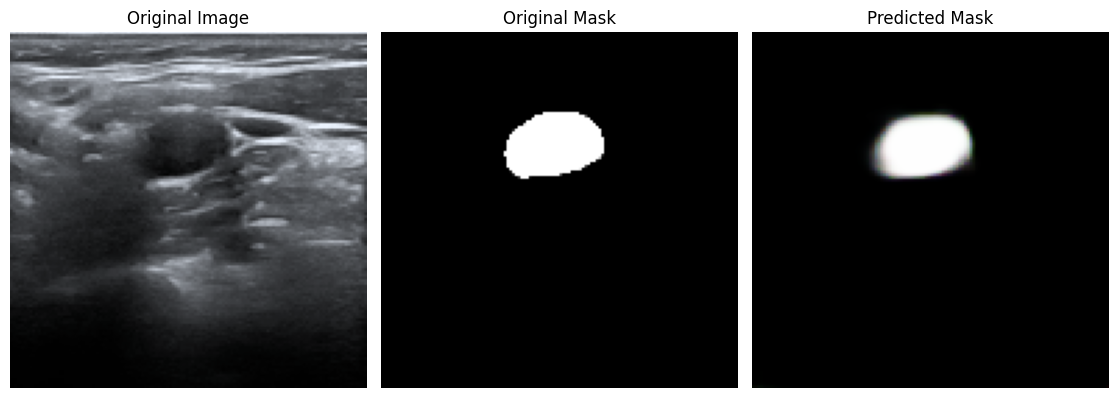

193/193 [==============================] - 229s 1s/step - loss: 0.0126 - accuracy: 0.6516 - IoU: 0.5001 - val_loss: 0.0096 - val_accuracy: 0.7226 - val_IoU: 0.5291
Epoch 6/30
193/193 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.7025 - IoU: 0.5273

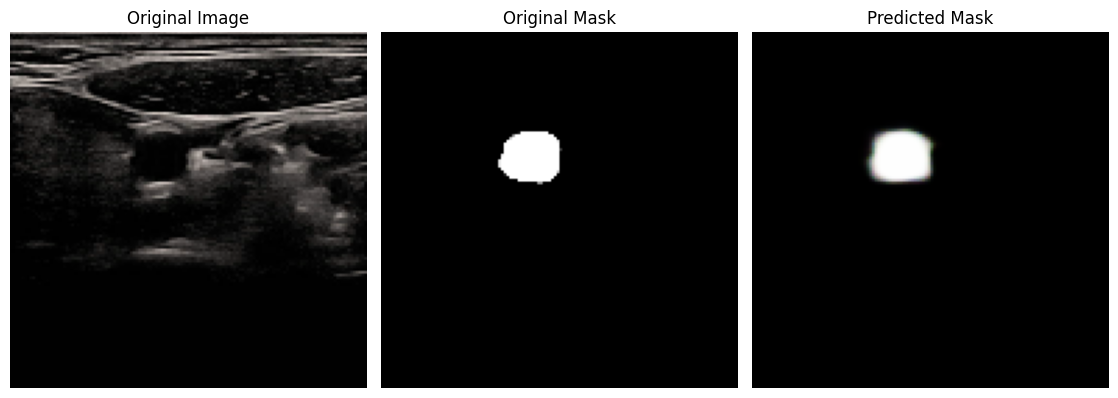

193/193 [==============================] - 228s 1s/step - loss: 0.0084 - accuracy: 0.7025 - IoU: 0.5273 - val_loss: 0.0086 - val_accuracy: 0.7348 - val_IoU: 0.5010
Epoch 7/30
193/193 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.7203 - IoU: 0.5296

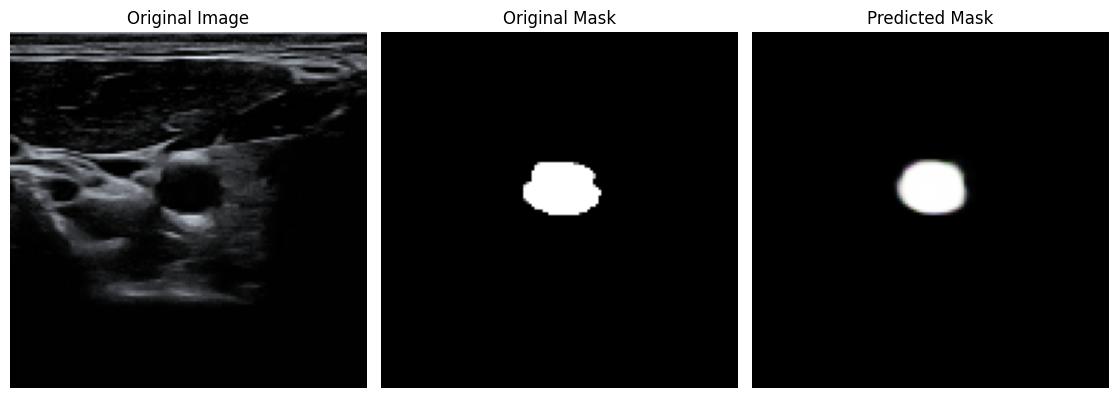

193/193 [==============================] - 228s 1s/step - loss: 0.0079 - accuracy: 0.7203 - IoU: 0.5296 - val_loss: 0.0064 - val_accuracy: 0.7068 - val_IoU: 0.5110
Epoch 8/30
193/193 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.7895 - IoU: 0.5682

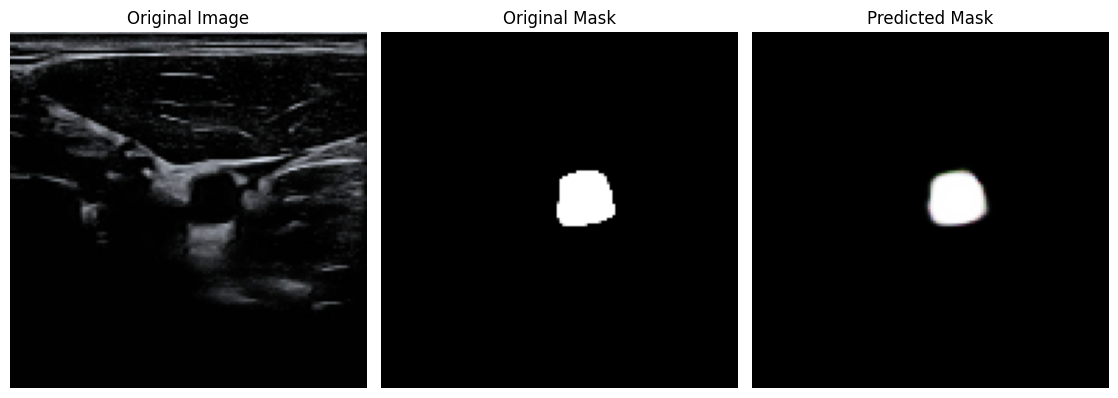

193/193 [==============================] - 228s 1s/step - loss: 0.0060 - accuracy: 0.7895 - IoU: 0.5682 - val_loss: 0.0062 - val_accuracy: 0.8002 - val_IoU: 0.5662
Epoch 9/30
193/193 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.8190 - IoU: 0.5866

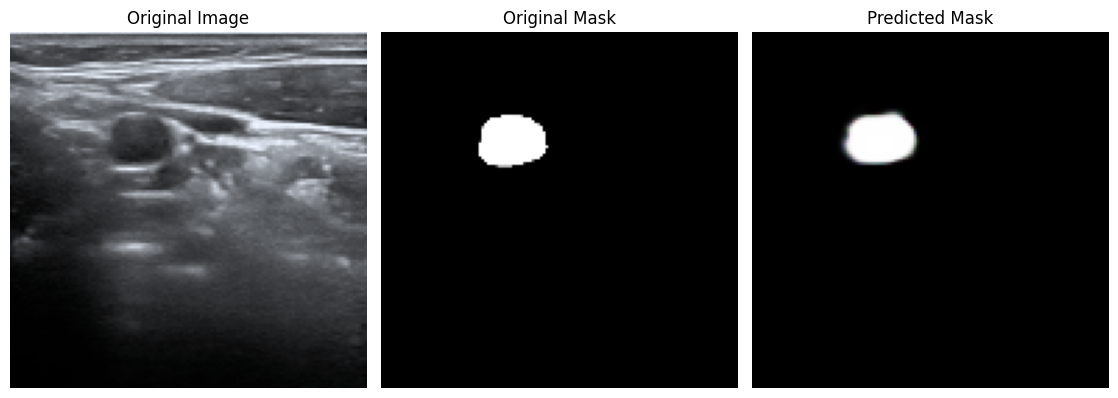

193/193 [==============================] - 227s 1s/step - loss: 0.0057 - accuracy: 0.8190 - IoU: 0.5866 - val_loss: 0.0060 - val_accuracy: 0.7980 - val_IoU: 0.5989
Epoch 10/30
193/193 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.8162 - IoU: 0.5479

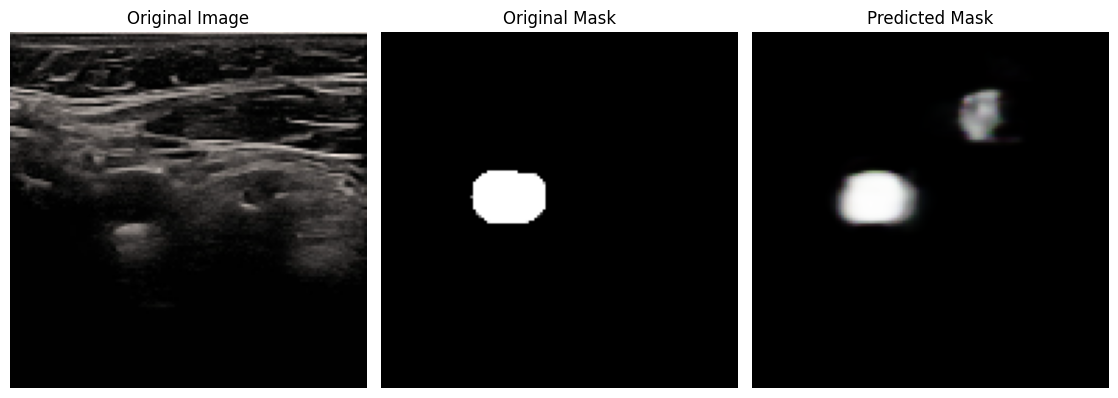

193/193 [==============================] - 227s 1s/step - loss: 0.0096 - accuracy: 0.8162 - IoU: 0.5479 - val_loss: 0.0074 - val_accuracy: 0.7530 - val_IoU: 0.4957
Epoch 11/30
193/193 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.7956 - IoU: 0.5637

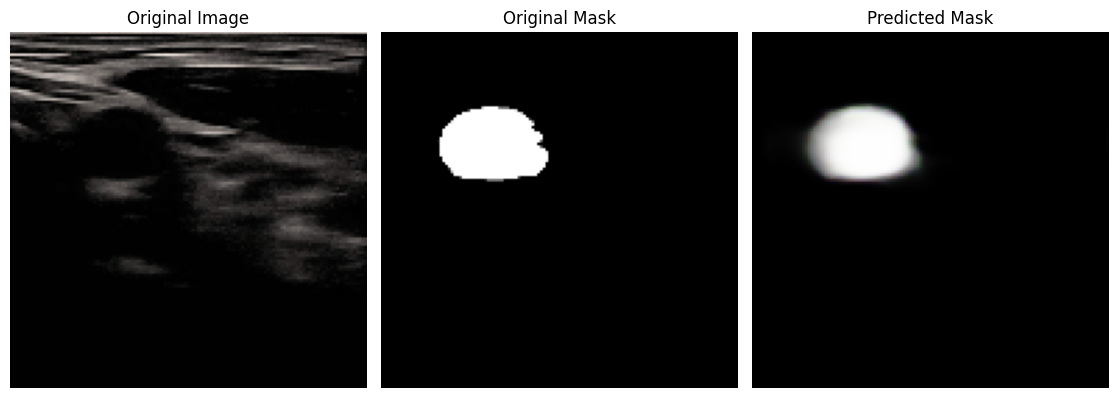

193/193 [==============================] - 226s 1s/step - loss: 0.0072 - accuracy: 0.7956 - IoU: 0.5637 - val_loss: 0.0069 - val_accuracy: 0.9016 - val_IoU: 0.5547
Epoch 12/30
193/193 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.7377 - IoU: 0.5270

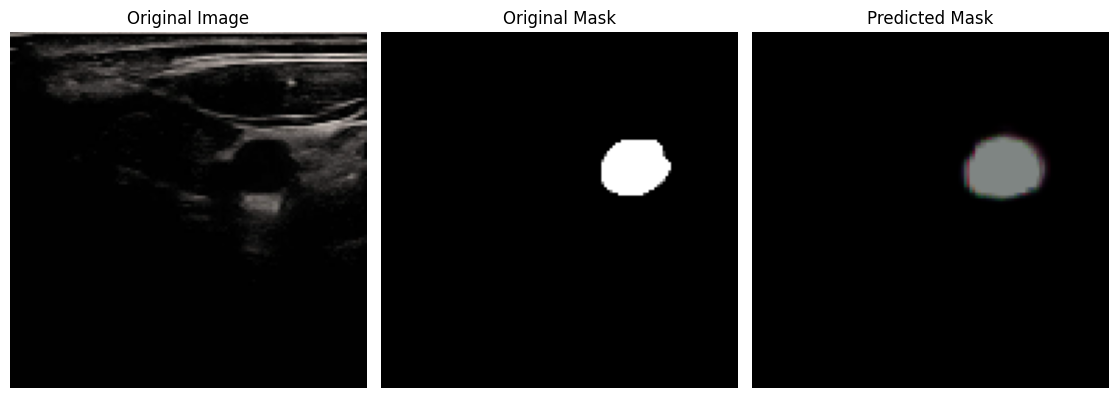

193/193 [==============================] - 227s 1s/step - loss: 0.0289 - accuracy: 0.7377 - IoU: 0.5270 - val_loss: 0.0229 - val_accuracy: 0.8787 - val_IoU: 0.4884
Epoch 13/30
193/193 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.8233 - IoU: 0.4885

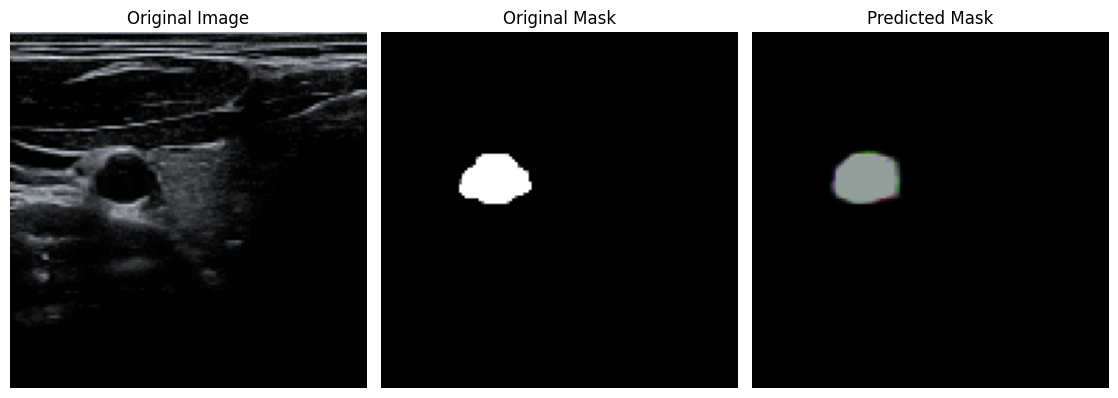

193/193 [==============================] - 227s 1s/step - loss: 0.0200 - accuracy: 0.8233 - IoU: 0.4885 - val_loss: 0.0182 - val_accuracy: 0.8927 - val_IoU: 0.4884
Epoch 14/30
193/193 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.8531 - IoU: 0.4926

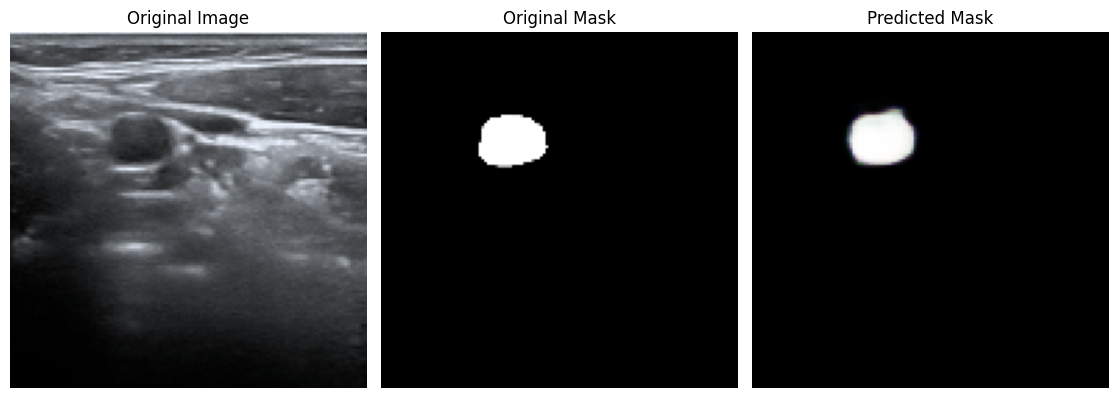

193/193 [==============================] - 227s 1s/step - loss: 0.0140 - accuracy: 0.8531 - IoU: 0.4926 - val_loss: 0.0085 - val_accuracy: 0.9383 - val_IoU: 0.4884
Epoch 15/30
193/193 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9095 - IoU: 0.5306

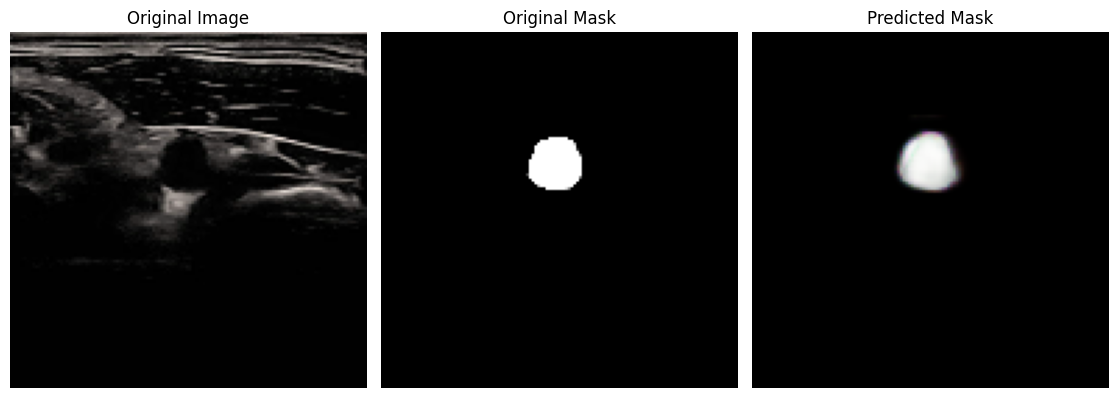

193/193 [==============================] - 227s 1s/step - loss: 0.0078 - accuracy: 0.9095 - IoU: 0.5306 - val_loss: 0.0151 - val_accuracy: 0.9383 - val_IoU: 0.4884
Epoch 16/30
193/193 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.8215 - IoU: 0.5109

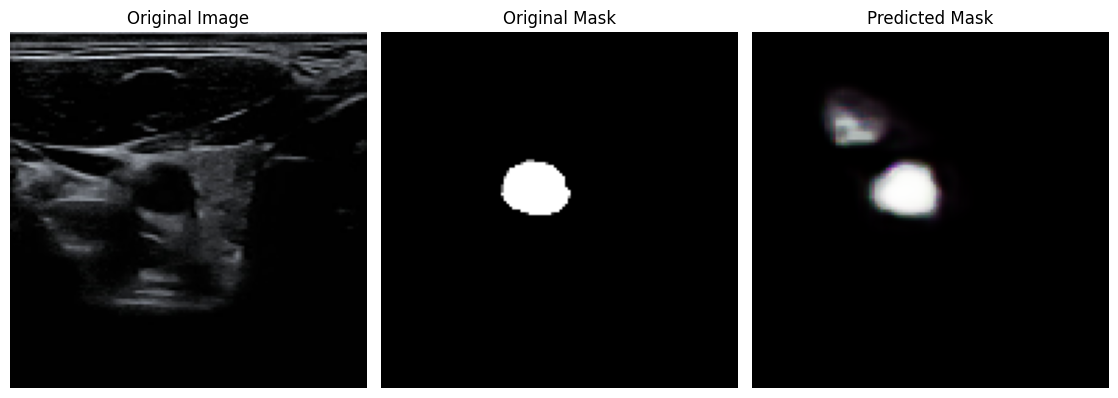

193/193 [==============================] - 233s 1s/step - loss: 0.0171 - accuracy: 0.8215 - IoU: 0.5109 - val_loss: 0.0144 - val_accuracy: 0.8115 - val_IoU: 0.4884
Epoch 17/30
193/193 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.6268 - IoU: 0.4916

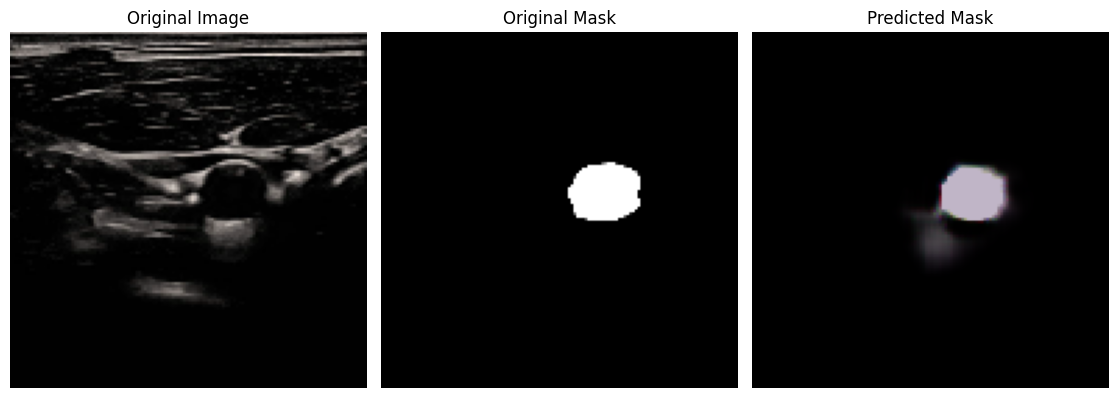

193/193 [==============================] - 239s 1s/step - loss: 0.0293 - accuracy: 0.6268 - IoU: 0.4916 - val_loss: 0.0231 - val_accuracy: 0.4141 - val_IoU: 0.4884
Epoch 18/30
193/193 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.8163 - IoU: 0.4885

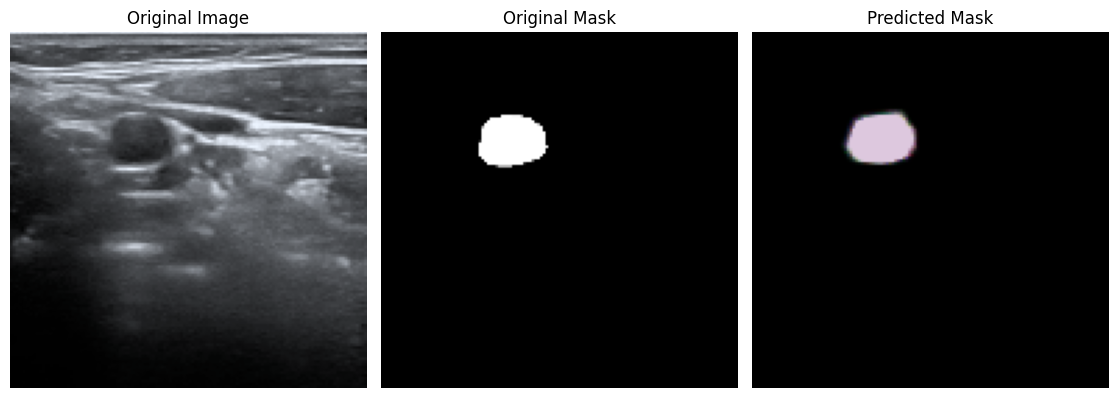

193/193 [==============================] - 227s 1s/step - loss: 0.0139 - accuracy: 0.8163 - IoU: 0.4885 - val_loss: 0.0109 - val_accuracy: 0.9076 - val_IoU: 0.4884
Epoch 19/30
193/193 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.8227 - IoU: 0.4885

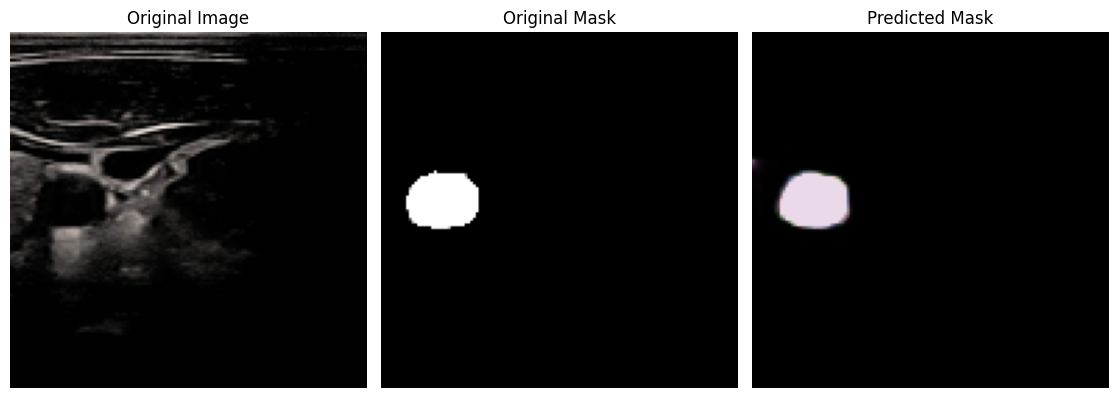

193/193 [==============================] - 219s 1s/step - loss: 0.0126 - accuracy: 0.8227 - IoU: 0.4885 - val_loss: 0.0095 - val_accuracy: 0.8580 - val_IoU: 0.4884
Epoch 20/30
193/193 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.8382 - IoU: 0.4885

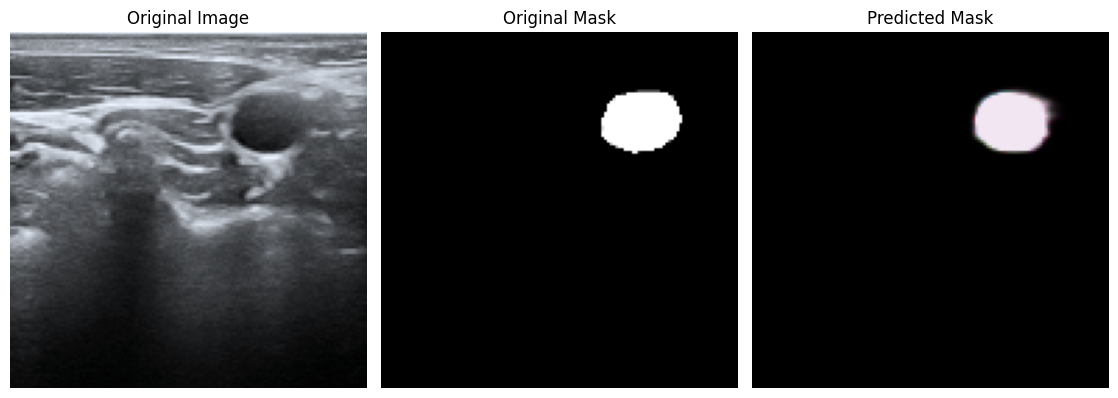

193/193 [==============================] - 218s 1s/step - loss: 0.0091 - accuracy: 0.8382 - IoU: 0.4885 - val_loss: 0.0089 - val_accuracy: 0.8907 - val_IoU: 0.4884
Epoch 21/30
193/193 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.8921 - IoU: 0.4885

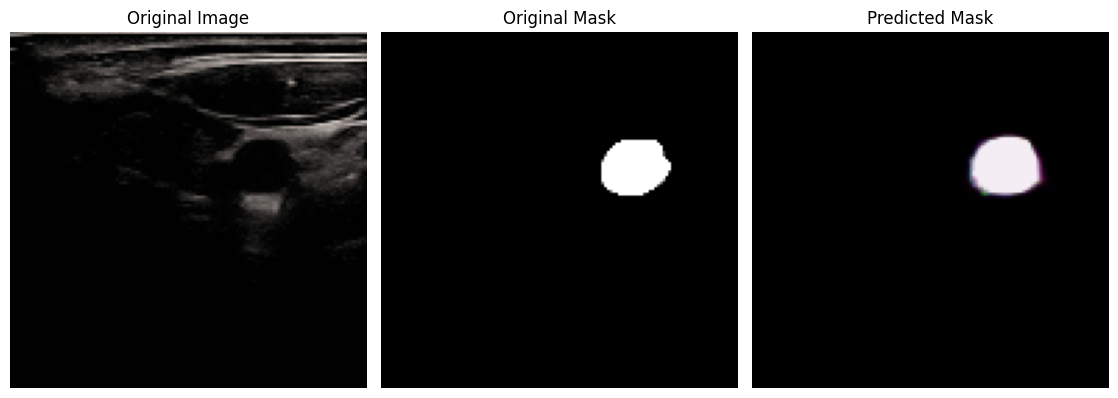

193/193 [==============================] - 219s 1s/step - loss: 0.0090 - accuracy: 0.8921 - IoU: 0.4885 - val_loss: 0.0076 - val_accuracy: 0.8786 - val_IoU: 0.4884
Epoch 22/30
193/193 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.8779 - IoU: 0.4885

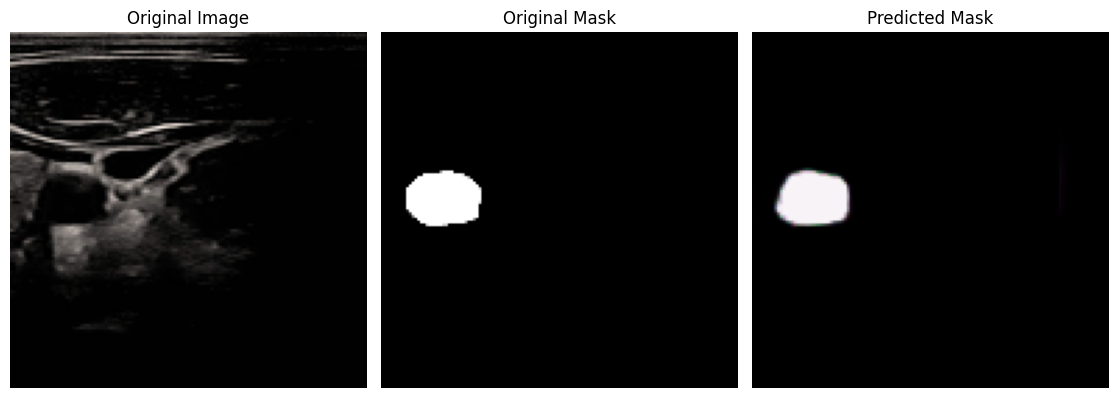

193/193 [==============================] - 218s 1s/step - loss: 0.0074 - accuracy: 0.8779 - IoU: 0.4885 - val_loss: 0.0070 - val_accuracy: 0.8361 - val_IoU: 0.4884
Epoch 23/30
193/193 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.8634 - IoU: 0.4885

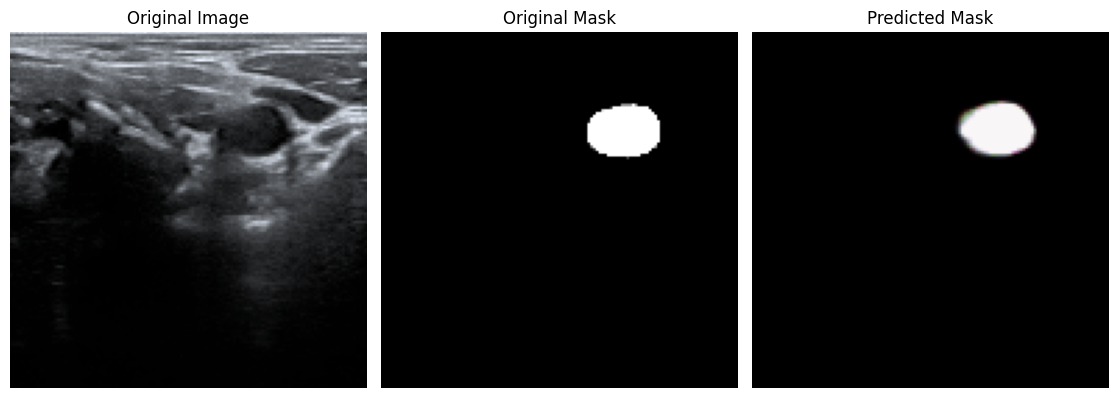

193/193 [==============================] - 218s 1s/step - loss: 0.0069 - accuracy: 0.8634 - IoU: 0.4885 - val_loss: 0.0068 - val_accuracy: 0.8774 - val_IoU: 0.4884
Epoch 24/30
193/193 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.8949 - IoU: 0.4885

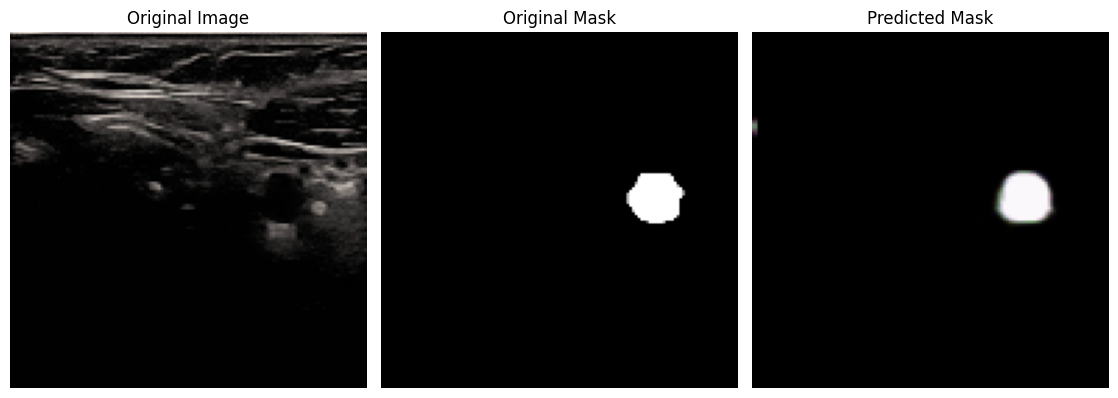

193/193 [==============================] - 217s 1s/step - loss: 0.0062 - accuracy: 0.8949 - IoU: 0.4885 - val_loss: 0.0065 - val_accuracy: 0.8790 - val_IoU: 0.4884
Epoch 25/30
193/193 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.8964 - IoU: 0.4885

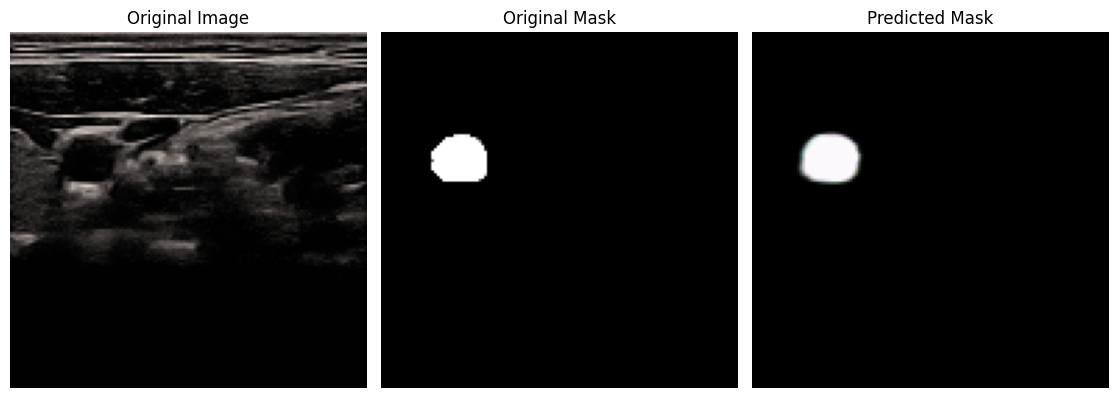

193/193 [==============================] - 219s 1s/step - loss: 0.0058 - accuracy: 0.8964 - IoU: 0.4885 - val_loss: 0.0062 - val_accuracy: 0.9059 - val_IoU: 0.4884
Epoch 26/30
193/193 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9104 - IoU: 0.4885

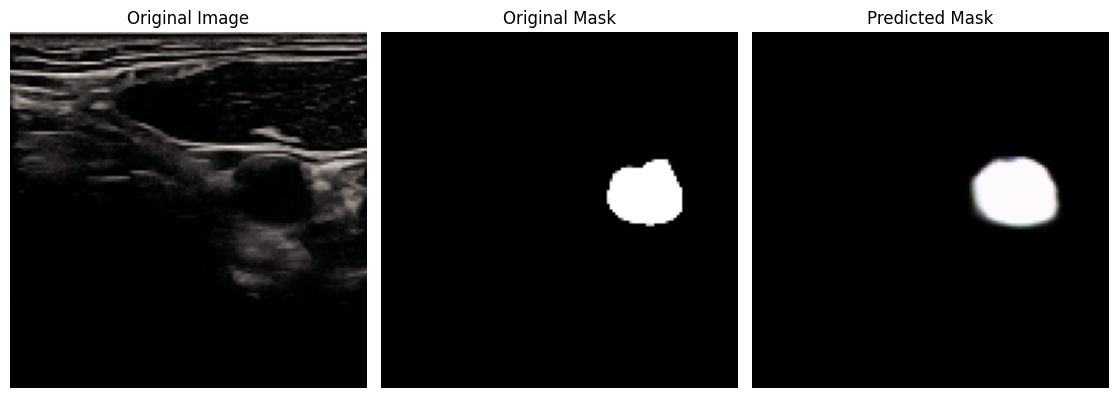

193/193 [==============================] - 218s 1s/step - loss: 0.0056 - accuracy: 0.9104 - IoU: 0.4885 - val_loss: 0.0061 - val_accuracy: 0.9299 - val_IoU: 0.4884
Epoch 27/30
193/193 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9274 - IoU: 0.4885

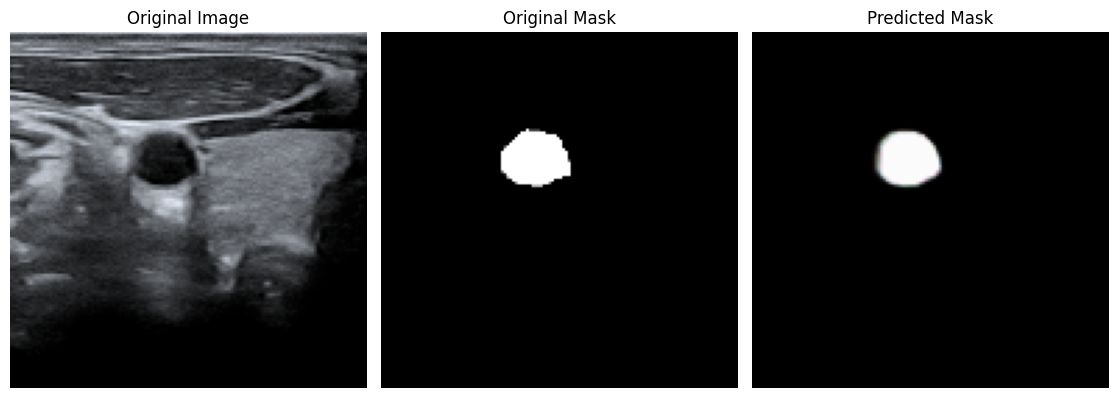

193/193 [==============================] - 217s 1s/step - loss: 0.0054 - accuracy: 0.9274 - IoU: 0.4885 - val_loss: 0.0061 - val_accuracy: 0.9370 - val_IoU: 0.4884
Epoch 28/30
193/193 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9386 - IoU: 0.4885

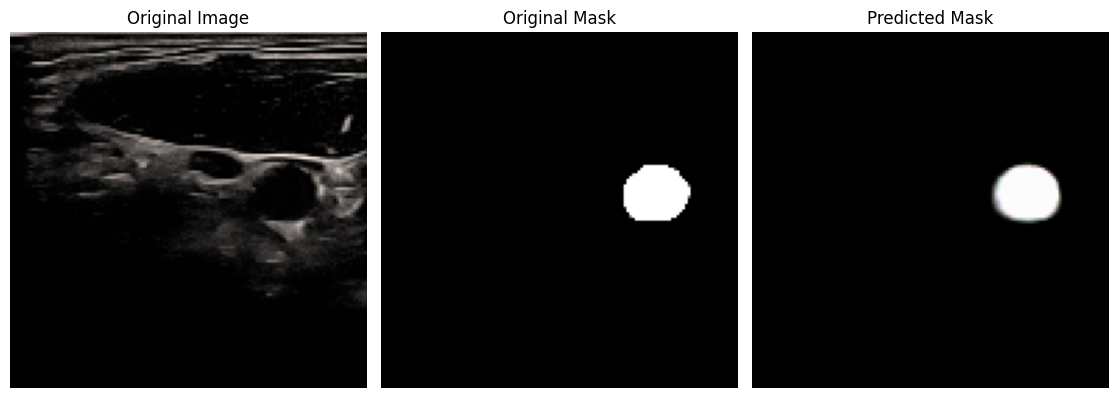

193/193 [==============================] - 217s 1s/step - loss: 0.0054 - accuracy: 0.9386 - IoU: 0.4885 - val_loss: 0.0062 - val_accuracy: 0.9434 - val_IoU: 0.4884
Epoch 29/30
193/193 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9299 - IoU: 0.4885

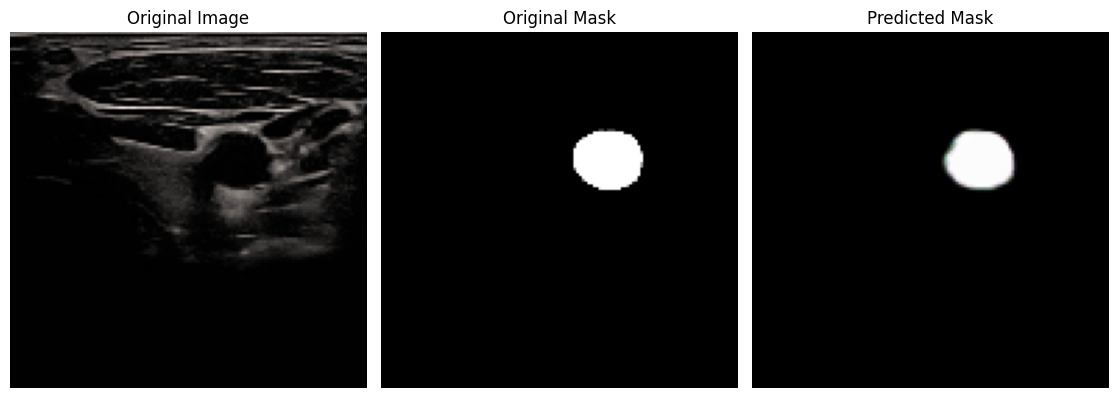

193/193 [==============================] - 217s 1s/step - loss: 0.0052 - accuracy: 0.9299 - IoU: 0.4885 - val_loss: 0.0059 - val_accuracy: 0.9498 - val_IoU: 0.4884
Epoch 30/30
193/193 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9394 - IoU: 0.4885

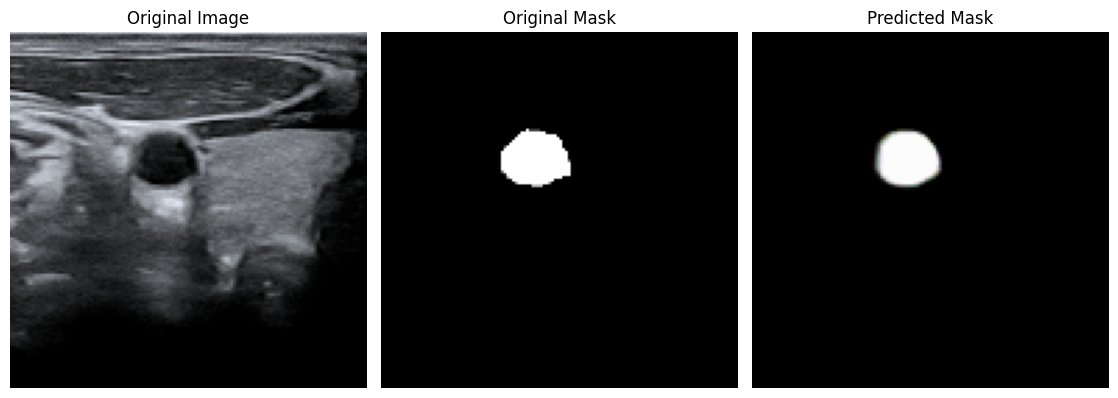

193/193 [==============================] - 218s 1s/step - loss: 0.0051 - accuracy: 0.9394 - IoU: 0.4885 - val_loss: 0.0062 - val_accuracy: 0.9518 - val_IoU: 0.4884


In [14]:
# training
results = att_unet.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=30,
    callbacks=[
#         EarlyStopping(patience=3, monitor='IoU', mode='max', restore_best_weights=True),
        ShowProgress()],
    batch_size=4
)

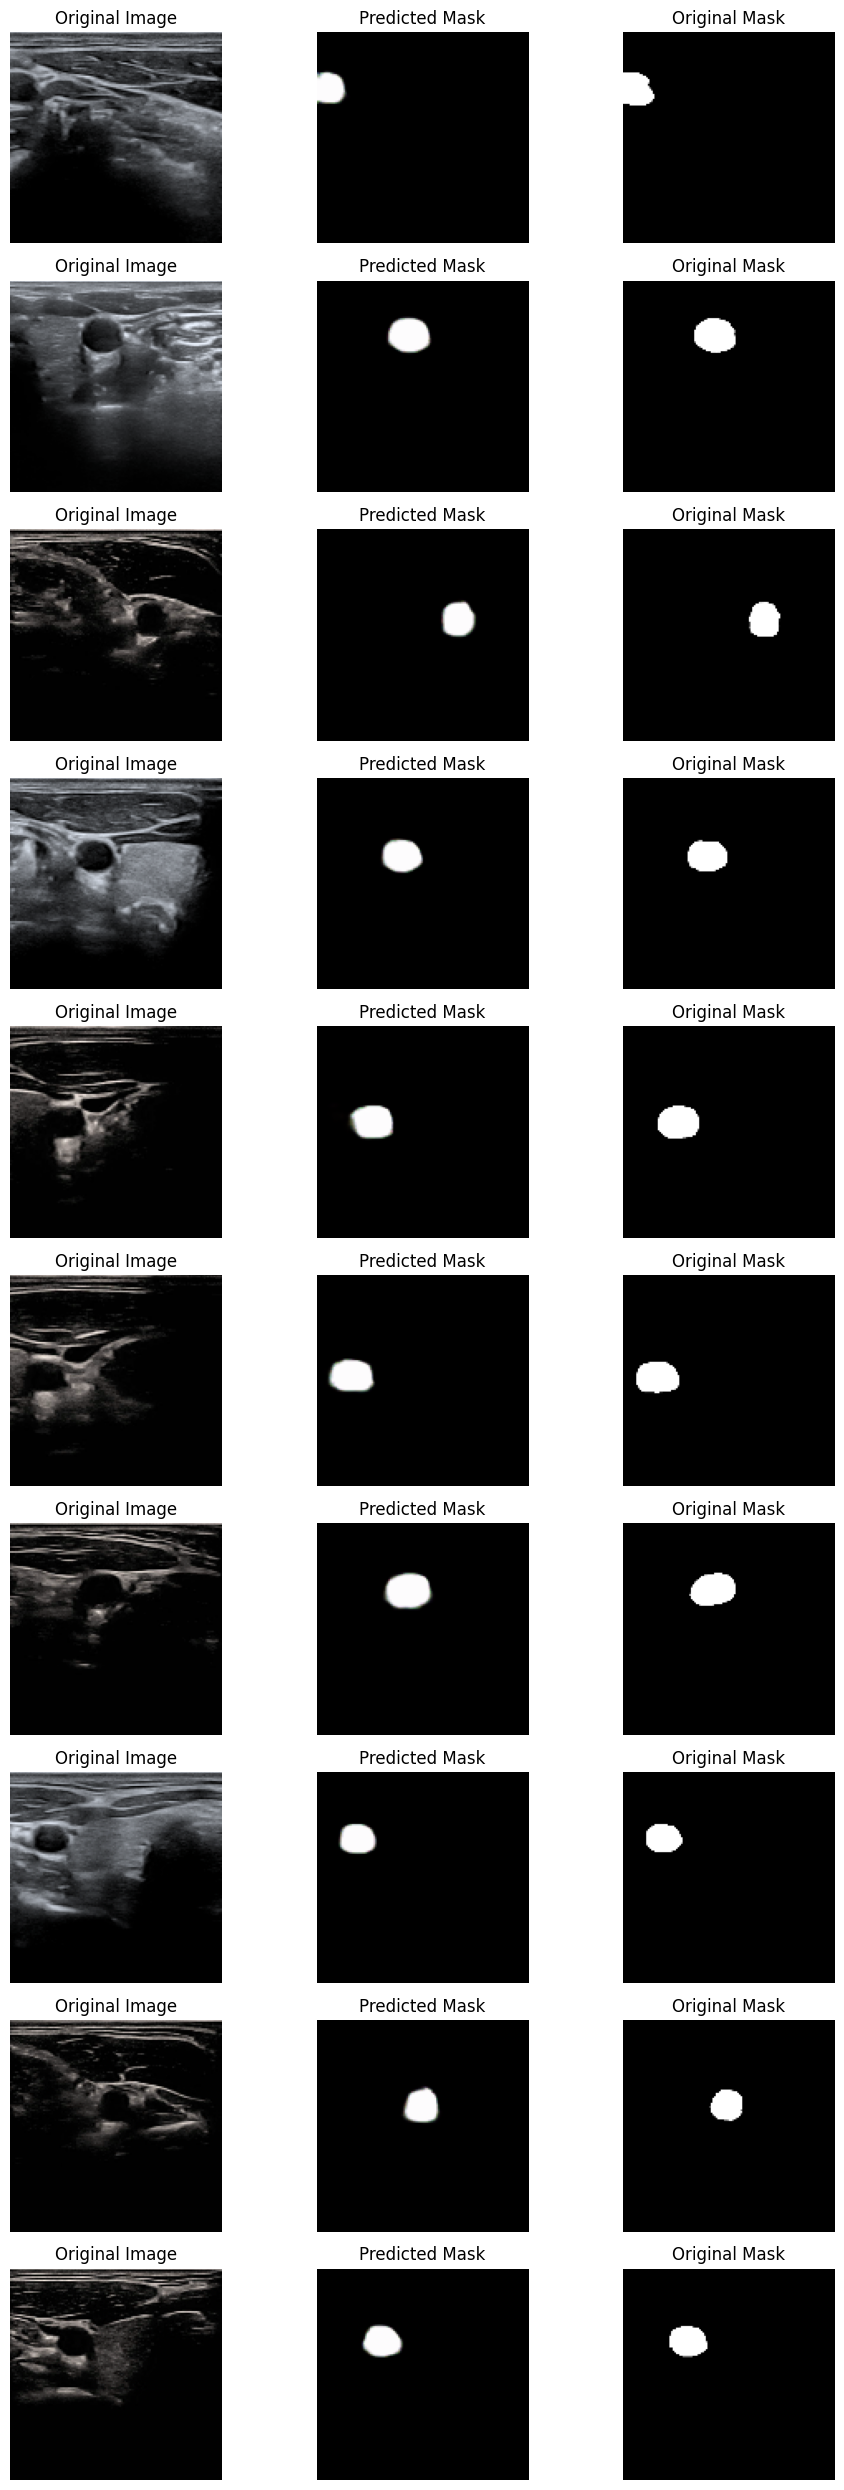

In [15]:
plt.figure(figsize=(10,25))
n = 0
for i in range(1,(10*3)+1):
    plt.subplot(10,3,i)
    if n == 0:
        id = np.random.randint(len(test_images))
        image = test_images[id][np.newaxis,...]
        mask = test_masks[id]
        pred_mask = att_unet.predict(image)[0]
        image = image[0]
        show_image(image, title="Original Image")
        n+=1
    elif n==1:
        show_image(pred_mask,"Predicted Mask")
        n+=1
    elif n==2:
        show_image(mask,title="Original Mask")
        n=0
plt.tight_layout()
plt.show()